In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from parser import parser
from config import DATA_DOWNLOAD_URL
import geopandas
from shapely.prepared import prep
import os
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
geo = geopandas.read_file("data/geojsonfrance_corse_20.json")
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)
geo

,code,nom,geometry
0,1,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,2,Aisne,"POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21..."
2,3,Allier,"POLYGON ((3.03206 46.79491, 3.03684 46.7844, 3..."
3,4,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,5,Hautes-Alpes,"POLYGON ((6.26057 45.12684, 6.2755 45.1153, 6...."
...,...,...,...
90,91,Essonne,"POLYGON ((2.22655 48.7761, 2.23297 48.76619, 2..."
91,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.32697 48.94536, ..."
92,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.56579 49.0124, 2..."
93,94,Val-de-Marne,"POLYGON ((2.3319 48.81701, 2.36395 48.81631, 2..."


In [ ]:
#We are making files for every france departement with points it have in it for the 250m grid from MODIS data.
#We will use these point to extract the values for historical data
#It it possible to do everything in one script, without saving the grid on external files, but my machine is not powerfull enough
for _,dep in geo.iterrows():
    res = {"name": dep["nom"], "code": dep["code"], "valid_lon": [], "valid_lat": []}
    for file in os.listdir(f"{DATA_DOWNLOAD_URL}/2025-01-16/"):
        valid_points = []
        hdfData = parser(f"{DATA_DOWNLOAD_URL}/2025-01-16/{file}")
        lons_flatten = hdfData["lons"].flatten() #reminder : non flatten coordinates are (4800, 4800), if we want to acces the 500 row and the 1000 column, the index will be 500*4800 + 1000 for the flatten array
        lats_flatten = hdfData["lats"].flatten()
        data_flatten = hdfData["datas"].flatten()

        points = geopandas.points_from_xy(x=lons_flatten, y=lats_flatten) #list of points from flattened lat and lon
        
        point_index_map = {point: idx for idx, point in enumerate(points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

        prepared = prep(dep["geometry"]) #prep polygon for batch operation on large point list
        
        valid_points.extend(filter(prepared.contains, points)) #seach for valid points inside polygon
        
        valid_indices = [point_index_map[point] for point in valid_points if point in point_index_map] #get indexes for valid_point found
        
        valid_lon = [point.x for point in valid_points] #lon and lat from indices
        valid_lat = [point.y for point in valid_points]

        res["valid_lon"].extend(valid_lon)
        res["valid_lat"].extend(valid_lat)
    with open(f"data/coords/{dep["code"]}-{dep["nom"]}.json", "w") as outfile: 
        json.dump(res, outfile)

In [3]:
data1 = parser(f"{DATA_DOWNLOAD_URL}/2025-01-16/MOD13Q1.A2025001.h17v04.061.2025022084544.hdf")
#data2 = parser(f"{DATA_DOWNLOAD_URL}/2025-01-16/MOD13Q1.A2025001.h18v03.061.2025022080925.hdf")
#data3 = parser(f"{DATA_DOWNLOAD_URL}/2025-01-16/MOD13Q1.A2025001.h18v04.061.2025022083416.hdf")

c:\Users\alexl\miniconda3\envs\conda-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\alexl\Documents\GitHub\Meteo\Satellite\NDVI\parser.py:51: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat= pyproj.transform(sinu, wgs84, xv, yv)


In [4]:
lons_flatten = data1["lons"].flatten() #reminder : non flatten coordinates are (4800, 4800), if we want to acces the 500 row and the 1000 column, the index will be 500*4800 + 1000 for the flatten array
lats_flatten = data1["lats"].flatten()
data_flatten = data1["datas"].flatten()

In [5]:
points = geopandas.points_from_xy(x=lons_flatten, y=lats_flatten) #list of points from flattened lat and lon

In [ ]:
point_index_map = {point: idx for idx, point in enumerate(points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [7]:
prepared = prep(geo.geometry.iloc[92]) #prep polygon for batch operation on large point list

In [8]:
valid_points = []
valid_points.extend(filter(prepared.contains, points)) #seach for valid points inside polygon

In [9]:
valid_indices = [point_index_map[point] for point in valid_points if point in point_index_map] #get indexes for valid_point found

In [10]:
valid_lon = [point.x for point in valid_points] #lon and lat from indices
valid_lat = [point.y for point in valid_points]

In [ ]:
valid_data = [data_flatten[i] for i in valid_indices] #get data from indices list

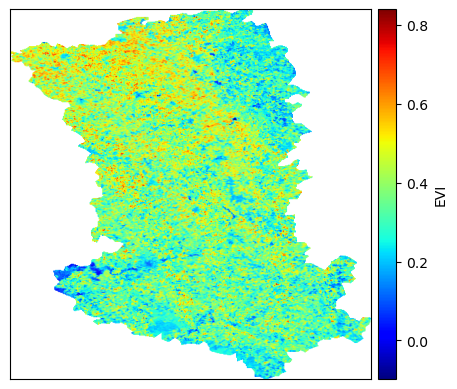

In [5]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(res["valid_lat"]),  urcrnrlat=np.max(res["valid_lat"]),
            llcrnrlon=np.min(res["valid_lon"]), urcrnrlon=np.max(res["valid_lon"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(res["valid_lon"], res["valid_lat"], c=res["valid_data"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

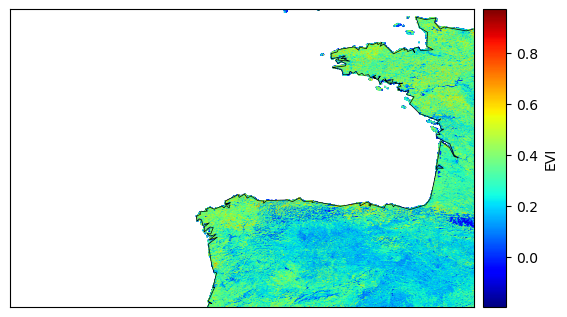

In [49]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data1["lats"]),  urcrnrlat=np.max(data1["lats"]),
            llcrnrlon=np.min(data1["lons"]), urcrnrlon=np.max(data1["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data1["lons"], data1["lats"], c=data1["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

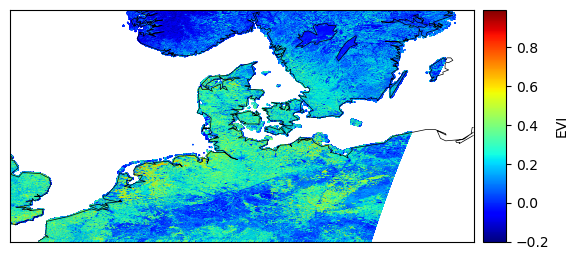

In [50]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data2["lats"]),  urcrnrlat=np.max(data2["lats"]),
            llcrnrlon=np.min(data2["lons"]), urcrnrlon=np.max(data2["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data2["lons"], data2["lats"], c=data2["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

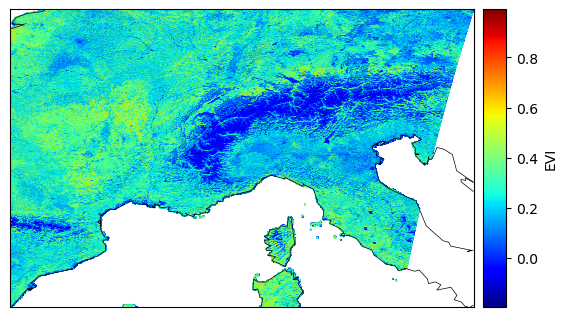

In [51]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data3["lats"]),  urcrnrlat=np.max(data3["lats"]),
            llcrnrlon=np.min(data3["lons"]), urcrnrlon=np.max(data3["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data3["lons"], data3["lats"], c=data3["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()